# Symplectic ODE Integrators

The aim of this talk is to provide an introduction to symplectic ODE solvers. In a single, short talk, the maths is probably a bit too complex to fully dive into, so the idea here is just to attempt to give and intuitive feeling about what they are all about.

## Motivation

Suppose we are NASA, and we want to put a person on the moon. To do this, we first need to understand how the moon moves.

From Newton's laws, we know that the position of the moon $q$, relative to the earth, satisfies the ODE

$$
\ddot{q} = - \frac{q}{||q||^3},
$$

where the constants have been set to $1$ for simplicity.

We can write this as a system of first order ODEs

$$
\dot{y} = f(y),
$$

by taking

$$
y = \begin{pmatrix}
        q \\
        p
    \end{pmatrix}

\textnormal{ and } f(y) = \begin{pmatrix}
                                p \\
                                - \frac{q}{||q||^3}
                            \end{pmatrix},

$$

where $p = \dot{q}$. (This is Hamilton's perspective.)

A well known and simple method of approximating the solution to systems of this form is the explicit Euler method, given by

$$
y_{n + 1} = y_n + hf(y_n).
$$

Let's solve the system using this method.

In [70]:
import numpy as np


def explicit_euler(f, y_i, t_f, n):
    t = np.zeros(n + 1)
    y = np.zeros((y_i.shape[0], n + 1))
    y[:, 0] = y_i
    h = t_f / n
    for i in range(n):
        y[:, i + 1] = y[:, i] + h * f(t[i], y[:, i])
        t[i + 1] = t[i] + h
    return t, y


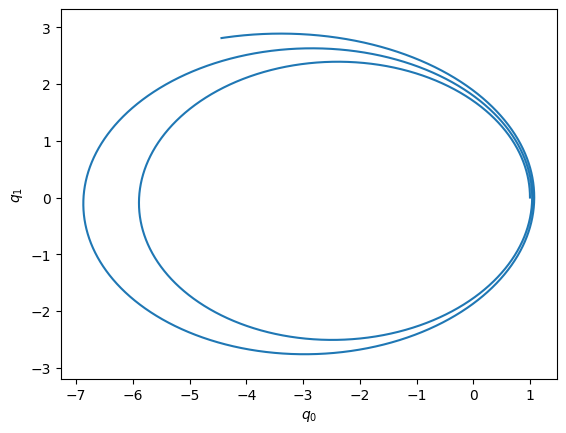

In [87]:
from matplotlib import pyplot as plt

def f_two_body(t, y):
    x_0, x_1, v_0, v_1 = y[0], y[1], y[2], y[3]
    a_0 = - x_0 / (x_0**2 + x_1**2)**(3 / 2)
    a_1 = - x_1 / (x_0**2 + x_1**2)**(3 / 2)
    return np.array([v_0, v_1, a_0, a_1])


# Initial condition y = [x_0, x_1, v_0, v_1]
y_i = np.array([1.0, 0.0, 0.0, 1.3])

# Final time
t_f = 100

# Number of time steps
n = 10000

t, y_ex_euler = explicit_euler(f_two_body, y_i, t_f, n)
plt.plot(y_ex_euler[0, :], y_ex_euler[1, :], "-")
plt.axis("equal")
plt.xlabel("$q_0$")
plt.ylabel("$q_1$")
plt.show()

Uh Oh, we're losing the moon! Try changing the time step and the final time to see the effect on the the orbit.

(Incidentally, the moon is actually (slowly) getting further away, but then mechanism is not explicit Euler!)

Let's try implicit Euler instead, given by

$$
y_{n + 1} = y_n + hf(y_{n + 1}).
$$

Since we don't know $y_{n + 1}$, we must, in general, solve a non-linear equation at each time step; implicit Euler is more expensive than explicit Euler.

In [72]:
from scipy.optimize import newton

def implicit_euler(f, y_i, t_f, n):
    t = np.zeros(n + 1)
    y = np.zeros((y_i.shape[0], n + 1))
    y[:, 0] = y_i
    h = t_f / n
    for i in range(n):
        y[:, i + 1] = newton(lambda y_np1: y_np1 - h * f(t[i], y_np1) - y[:, i], y[:, i])
        t[i + 1] = t[i] + h
    return t, y

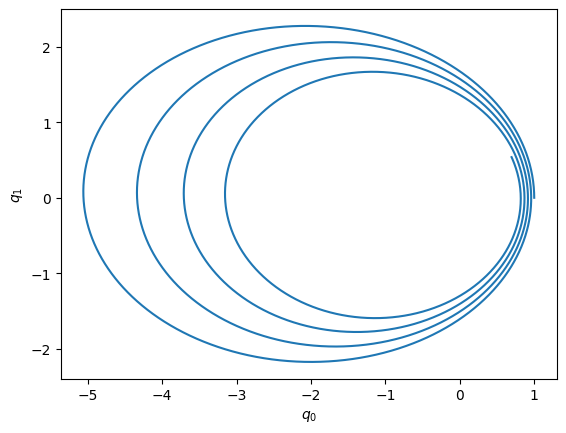

In [88]:
t, y_im_euler = implicit_euler(f_two_body, y_i, t_f, n)
plt.plot(y_im_euler[0, :], y_im_euler[1, :], "-")
plt.xlabel("$q_0$")
plt.ylabel("$q_1$")
plt.show()

Now the moon is spiralling inwards an will eventually crash into earth! Are we all doomed?

What if we wanted to simulate for longer? Laskar and Gastineau [1] simulated the Solar System for 5 billion years. Since the system is chaotic, the simulated 2500 different initial conditions, changing the position of Mercury by a fraction of a millimetre each time. About 1% of the simulations resulted in Mercury colliding with Venus or the Sun. 

Let's try another method, called symplectic Euler, which in this case is given by

$$
q_{n+1} = q_n + h p_n
$$
$$
p_{n+1} = p_n - h \frac{q_{n + 1}}{||q_{n + 1}||^3}.
$$

The only difference between symplectic Euler and explicit Euler is that we update the velocity with the newly calculated position. Symplectic Euler is still explicit, and it requires the same amount of work as explicit Euler.

In [ ]:
def symplectic_euler_two_body(y_i, t_f, n):
    t = np.zeros(n + 1)
    y = np.zeros((y_i.shape[0], n + 1))
    y[:, 0] = y_i
    h = t_f / n
    for i in range(n):
        y[0:2, i + 1] = y[0:2, i] + h * y[2:4, i]
        y[2:4, i + 1] = y[2:4, i] - h * y[0:2, i + 1] / np.linalg.norm(y[0:2, i + 1])**3
        t[i + 1] = t[i] + h
    return t, y

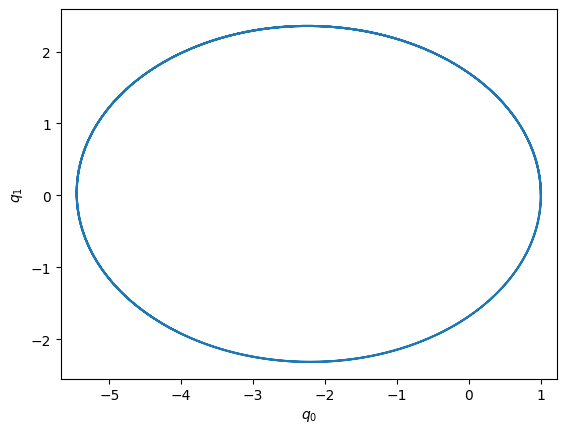

In [89]:
t, y_sym_euler = symplectic_euler_two_body(y_i, t_f, n)
plt.plot(y_sym_euler[0, :], y_sym_euler[1, :], "-")
plt.axis("equal")
plt.xlabel("$q_0$")
plt.ylabel("$q_1$")
plt.show()

Much better! But why?

Is it the order of approximation? Explicit, implicit, and symplectic Euler are all first-order accurate, so it can't be that!

## Lagrangian and Hamiltonian mechanics

You don't need to understand the details of Lagrangian and Hamiltonian mechanics to follow the rest of this talk, but the properties of Hamiltonian systems are so closely linked to sympleciticity that it has to be mentioned.

The principle of stationary action states that physical systems are characterised by a functional $L(q, \dot{q}, t)$ called the Lagrangian. Given a start point $q(t_0)$ and an end point $q(t_1)$ in a time interval $[t_0, t_1]$, the path followed by the system is such that the action

$$
S(q(t)) = \int_{t_0}^{t_1} L(q(t), \dot{q}(t), t) dt
$$

is stationary. All known laws of physics can be expressed like this, including classical mechanics, electromagnetism, general relativity, quantum physics, and the standard model of particle physics.

### Noether's theorem

One of the most beautiful theorems of physics: Noether's theorem states that every continuous symmetry of the action of a physical system with conservative forces has a corresponding conservation law.

What this essentially means is that, because the laws of physics that govern the universe now, also governed it in the past, and will govern it in the future, this necessarily implies that energy is conserved. Similarly, because the laws of physics are the same at any point in the universe, momentum is conserved.

The point is that the structure of the physical laws is very important to the existence of conservation laws. If we discretise the laws of physics with methods that don't respect the structure of the original equations, then we might find that our discrete universe doesn't conserve energy.


### Hamiltonian systems

Hamiltonian problems are of the form

$$
\dot{p} = - \partial_q H(p, q),
$$

$$
\dot{q} = \partial_p H(p, q),
$$

where the Hamiltonian $H$ is the total energy in the system, $q$ is the (generalised) coordinate, and $p$ is the (generalised) momentum. A simple consequence of this is that the Hamiltonian is invariant along solution curves i.e. $H(p(t), q(t)) = c$, where $c$ is a constant; Hamiltonian systems conserve energy.

The two-body problem we just looked at is a Hamiltonian problem with

$$
H(p, q) = \frac{1}{2} ||p||^2 - \frac{1}{||q||}.
$$

This is just the kinetic plus the potential energy. Plugging this into the above will give the same equations of motion we previously derived from Newton's laws.

Similarly, for a simple pendulum, the Hamiltonian is

$$
H(p, q) = \frac{1}{2} p^2 - \cos(q),
$$

where $q$ is the angle from the horizontal. The equations of motion are therefore

$$
\dot{p} = - sin(q)
$$

$$
\dot{q} = p.
$$

 We will focus on this system for simplicity.

### Phase space

Let's focus on the pendulum problem. If we give it some initial position $q$ (angle to the vertical), and some initial angular momentum $p$, then we know it's motion for all time $t$. Again, we can write the equations of motion in the form

$$
\dot{y} = f(y),
$$

where

$$
y = \begin{pmatrix}
        q \\
        p
    \end{pmatrix}

\textnormal{ and } f(y) = \begin{pmatrix}
                                p \\
                                - \sin(q)
                            \end{pmatrix}.

$$

It is helpful to think about the evolution of the system in phase space. The function $f(y)$ is a velocity field; it is the velocity of the solution through phase space.

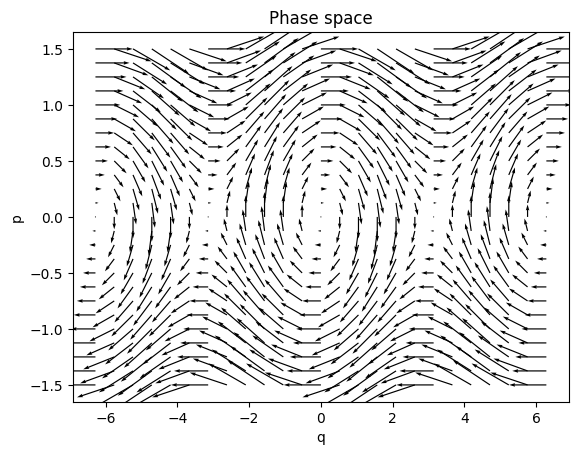

In [95]:
def f_pendulum(t, y):
    return np.array([y[1], - np.sin(y[0])])


def quiver(f_func):
    res = 25
    qs, ps = np.meshgrid(np.linspace(- 2 * np.pi, 2 * np.pi, res), np.linspace(-1.5, 1.5, res))

    f_0 = np.zeros_like(qs)
    f_1 = np.zeros_like(qs)
    for i in range(qs.shape[0]):
        for j in range(qs.shape[1]):
            f = f_func(0, np.array([qs[i, j], ps[i, j]]))
            f_0[i, j] = f[0]
            f_1[i, j] = f[1]
    plt.figure()
    plt.quiver(qs, ps, f_0, f_1, scale=20)
    plt.xlabel("q")
    plt.ylabel("p")
    plt.title("Phase space")

quiver(f_pendulum)

We can think of any point on the graph as an initial condition, and then follow  it as it is advected through the flow. Think about the different paths that are traced out and what that means for the pendulum. What is happening at the top and bottom?

Because the system is Hamiltonian, the flow velocity $f(y)$ is incompressible i.e. $\nabla \cdot f(y) = 0$. Thus, the streamlines form closed loops and the solutions are periodic. Note that since $q$ is an angle, the $q$ axis is $2 \pi$ periodic, and therefore phase space for the pendulum is topologically a cylinder.

By contrast, let's look at a non-Hamiltonian system, in this case a damped pendulum, for which we have

$$
f(y) = \begin{pmatrix}
                                p \\
                                - \mu p - \sin(q)
                            \end{pmatrix},

$$
where $\mu$ is a damping coefficient.

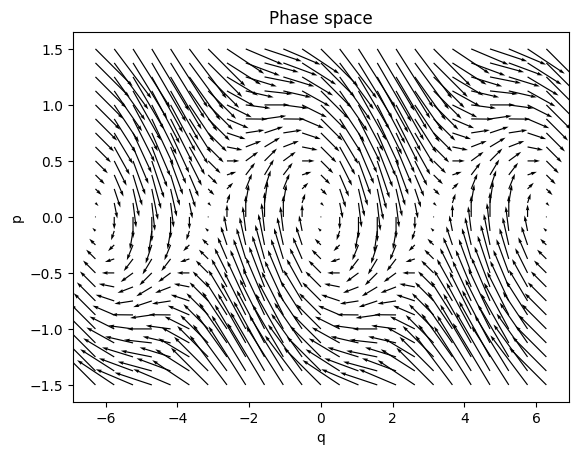

In [77]:
def f_damped_pendulum(t, y):
    mu = 1
    return np.array([y[1], - mu * y[1] - np.sin(y[0])])

quiver(f_damped_pendulum)

Notice how in this non-Hamiltonian system, whichever point we start at in phase space, we always spiral inwards, attracted to the sink in the centre. The flow $f(y)$ is not divergence free, the streamlines converge, volume isn't conserved, and the system loses energy over time.

Going back to our Hamiltonian pendulum, we know the Hamiltonian (total energy) is conserved along solution trajectories. If we plot level-curves of $H$, we see that the solution trajectory is constrained to the manifold defined by $H(p(t), q(t)) = c$, where $c = $H(p(0), q(0))$.

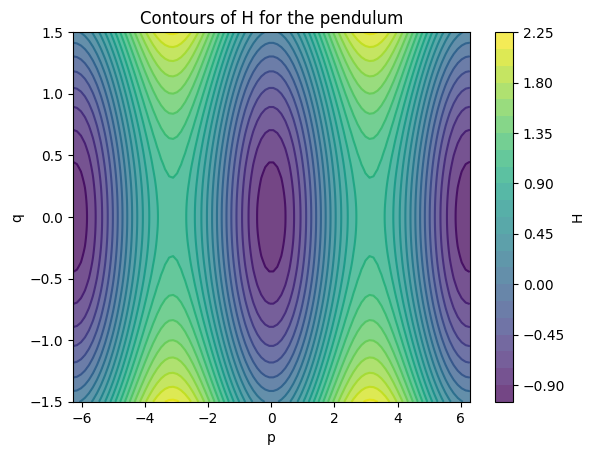

In [78]:
def H_pendulum(p, q):
    return 1 / 2 * p**2 - np.cos(q)


def contour(f):
    res = 100
    qs, ps = np.meshgrid(np.linspace(- 2 * np.pi, 2 * np.pi, res), np.linspace(-1.5, 1.5, res))
    H = f(ps, qs)
    plt.figure()
    plt.contour(qs, ps, H, levels=20, cmap="viridis")
    plt.contourf(qs, ps, H, levels=20, cmap="viridis", alpha=0.75)
    plt.colorbar(label="H")
    plt.xlabel("p")
    plt.ylabel("q")
    plt.title("Contours of H for the pendulum")

contour(H_pendulum)
plt.show()

## Symplectic methods

To see where explicit/implicit Euler are going wrong, lets solve the pendulum problem with explicit Euler and plot the result in physical and phase space.

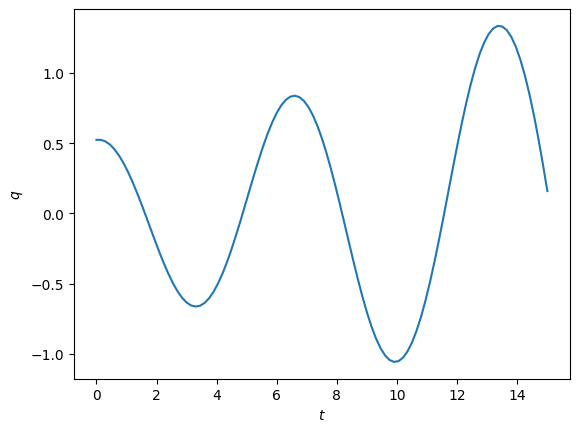

In [91]:
# y = [q, p]
y_i = np.array([np.deg2rad(30), 0])
t_f = 15
n = 100

t, y_ex_euler = explicit_euler(f_pendulum, y_i, t_f, n)
plt.plot(t, y_ex_euler[0, :], "-")
plt.xlabel("$t$")
plt.ylabel("$q$")
plt.show()

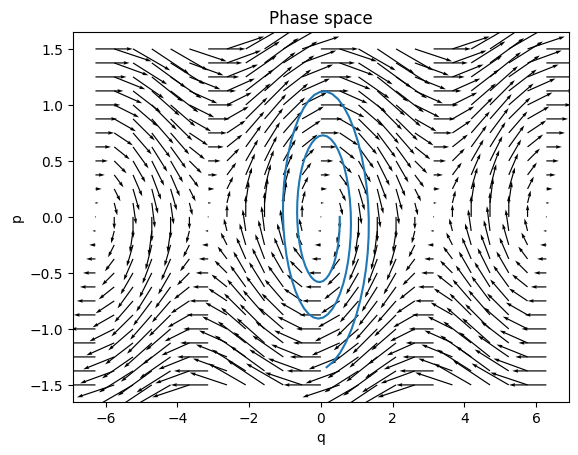

In [80]:
quiver(f_pendulum)
plt.plot(y_ex_euler[0, :], y_ex_euler[1, :], "-")


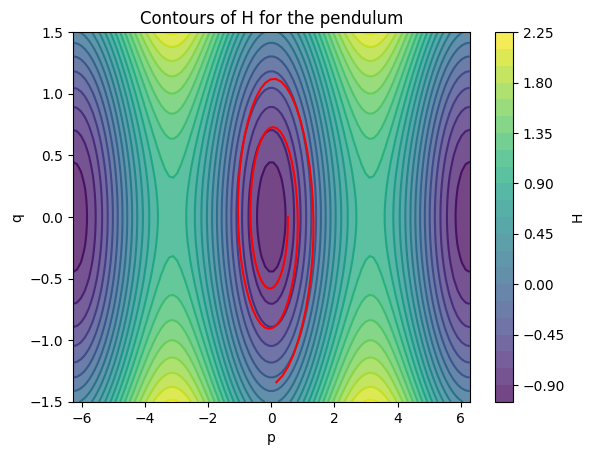

In [81]:
contour(H_pendulum)
plt.plot(y_ex_euler[0, :], y_ex_euler[1, :], "r-")


Explicit Euler advances the solution using the velocity $f(y_n)$ at the current point $y_n$. This means the solution's trajectory doesn't "curve" enough, and it strays from the manifold of constant $H$. It therefore spirals outwards on a trajectory of increasing energy.

The opposite is true for implicit Euler (try it).

The problem with explicit and implicit Euler is that as they advance the solution in time, the flow map does not preserve area. Streamlines diverge or converge, and the solution loses or gains energy.

Intuitively, it might seem reasonable to average the two approaches and evaluate the velocity $(y_n + y_{n + 1}) / 2$. Here, intuition serves us well and yields a scheme called implicit midpoint, which is symplectic. It is also symmetric, and so it is second order.

### Symplectic Euler

Now let's look at symplectic Euler:

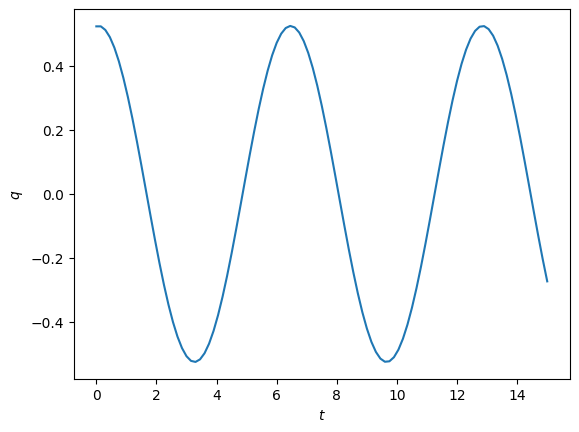

In [92]:
def symplectic_euler_pendulum(y_i, t_f, n):
    t = np.zeros(n + 1)
    y = np.zeros((y_i.shape[0], n + 1))
    y[:, 0] = y_i
    h = t_f / n
    for i in range(n):
        y[0, i + 1] = y[0, i] + h * y[1, i]
        y[1, i + 1] = y[1, i] - h * np.sin(y[0, i + 1])
        t[i + 1] = t[i] + h
    return t, y


t, y_sym_euler = symplectic_euler_pendulum(y_i, t_f, n)
plt.plot(t, y_sym_euler[0, :], "-")
plt.xlabel("$t$")
plt.ylabel("$q$")
plt.show()


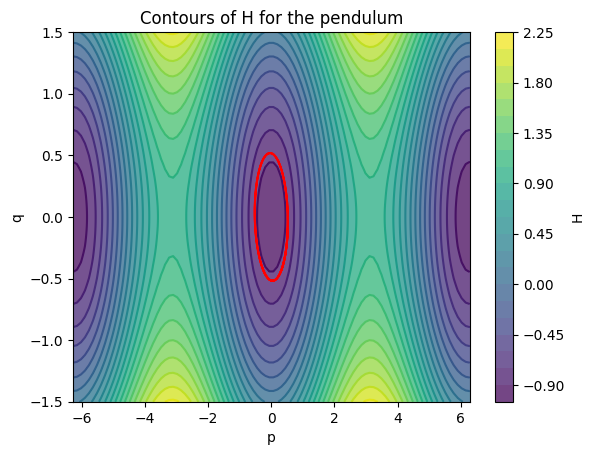

In [83]:
contour(H_pendulum)
plt.plot(y_sym_euler[0, :], y_sym_euler[1, :], "r-")

The flow map for symplectic Euler is volume preserving. This means that the symplectic integrators preserve the Hamiltonian character of a Hamiltonian differential equation (i.e. the discrete problem is also Hamiltonian). Hence, we have closed orbits and no dissipation etc

Another way to think of it is through backwards error analysis. Forwards error analysis asks "How is the solution changed by my discretisation?". Backwards error analysis asks "How is the problem changed by my discretisation?". In other words, what equation did my discretisation solve exactly?

Explicit and implicit Euler are exactly solving a new system that differs from the original by a term of $\mathcal{O}(h)$. Thus, we have a convergent method of first-order accuracy. However, the new system is not Hamiltonian, so we see dissipation etc.

Symplectic methods are also exactly solving a different problem, but crucially, this problem is also Hamiltonian. The new problem has a modified Hamiltonian $\tilde{H}$, which differs from the $H$ by a term of $\mathcal{O}(h)$ for symplectic Euler. As $h \to 0$, $\tilde{H} \to H$ and thus we have a convergent method with first-order accuracy. But, since the new system is still Hamiltonian, we don't get dissipation etc. Symplectic methods exactly solve a Hamiltonian problem that is an (arbitrarily small) perturbation away from the problem we are interested in.

Symplectic integrators conserve all quadratic invariants (including energy when it is quadratic). When energy isn't quadratic, conservation isn't exact, but it is bounded.

## Are symplectic methods always best?

No. Let's go back to our orbit problem. Symplectic Euler worked much better than implicit or explicit Euler, but it isn't flawless.

Solving for a longer period of time, we find that the orbit precesses, which is non-physical.

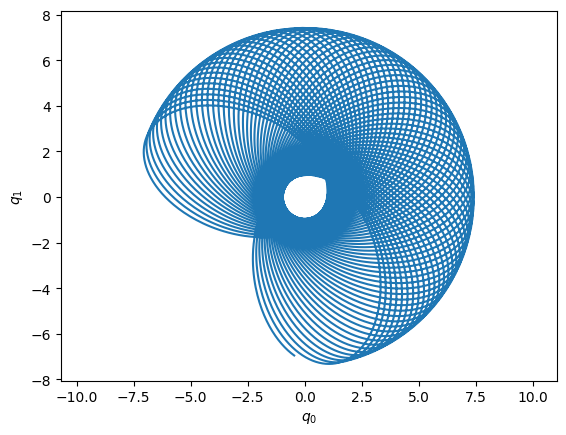

In [96]:
# Initial condition y = [x_0, x_1, v_0, v_1]
y_i = np.array([1.0, 0.0, 0.0, 1.3])

# Final time
t_f = 4000

# Number of time steps
n = 10000

t, y_sym_euler = symplectic_euler_two_body(y_i, t_f, n)
plt.plot(y_sym_euler[0, :], y_sym_euler[1, :], "-")
plt.axis("equal")
plt.xlabel("$q_0$")
plt.ylabel("$q_1$")
plt.show()

This is because the modified Hamiltonian $\tilde{H}$ contains an $\mathcal{O}(h)$ term that causes precession. We could improve this by reducing the time step $h$.

There are 3 key invariants in the Kepler problem:
- Energy ($H$)
- Angular momentum ($L$)
- The Runge-Lenz vector ($A$)

Roughly, $H$ and $L$ determine the shape and plane of the orbit, whilst $A$ encodes the orientation in that plane.

$H$ is not quadratic in this problem, so it isn't conserved exactly by symplectic Euler, but it is bounded. $L$ is quadratic, and so it is conserved exactly. $A$ is not conserved by symplectic Euler, so the orientation of the orbit will drift over long times.

It is possible to construct methods that conserve $H$, $L$, and $A$ simultaneously [3], but these methods are not symplectic. A theorem by Ge and Marsden says you can't have it all!

References:

[1] Laskar and Gastineau. "Existence of collisional trajectories of Mercury, Mars and Venus with the Earth", Nature, 2009

[2] Hairer, Lubich, and Wanner. "Geometric Numerical Integration", Springer Series in Computational Mathematics.

[3] Andrews and Farrell. "High-order conservative and accurately dissipative numerical integrators
    via auxiliary variables", Preprint on arXiv, 2025.